In [1]:
import sys
from sbml import create_model, outputSBML, check
from libsbml import *
import SBMLDiagrams
%load_ext autoreload
%autoreload 2

The tests rely on tellurium to construct the models
Since tellurium is not installed the tests can't be run
If you want to run the tests, pip install tellurium first


### Initialize Model

In [2]:
try:
    document = SBMLDocument(3, 2)
except ValueError:
    raise SystemExit('Could not create SBMLDocumention object')

model = document.createModel()

### Define Units

In [3]:
# Create the basic Model object inside the SBMLDocument object.  To
# produce a model with complete units for the reaction rates, we need
# to set the 'timeUnits' and 'extentUnits' attributes on Model.  We
# set 'substanceUnits' too, for good measure, though it's not strictly
# necessary here because we also set the units for invididual species
# in their definitions.

check(model,                              'create model')
check(model.setTimeUnits("second"),       'set model-wide time units')
check(model.setExtentUnits("mole"),       'set model units of extent')
check(model.setSubstanceUnits('mole'),    'set model substance units')

# Create a unit definition we will need later.  Note that SBML Unit
# objects must have all four attributes 'kind', 'exponent', 'scale'
# and 'multiplier' defined.

per_second = model.createUnitDefinition()
check(per_second,                         'create unit definition')
check(per_second.setId('per_second'),     'set unit definition id')
unit = per_second.createUnit()
check(unit,                               'create unit on per_second')
check(unit.setKind(UNIT_KIND_SECOND),     'set unit kind')
check(unit.setExponent(-1),               'set unit exponent')
check(unit.setScale(0),                   'set unit scale')
check(unit.setMultiplier(1),              'set unit multiplier')

### Define Compartment

In [4]:
# Create a compartment inside this model, and set the required
# attributes for an SBML compartment in SBML Level 3.

c1 = model.createCompartment()
check(c1,                                 'create compartment')
check(c1.setId('c1'),                     'set compartment id')
check(c1.setConstant(True),               'set compartment "constant"')
check(c1.setSize(1),                      'set compartment "size"')
check(c1.setSpatialDimensions(3),         'set compartment dimensions')
check(c1.setUnits('litre'),               'set compartment size units')

### Define Species

In [5]:
# Create two species inside this model, set the required attributes
# for each species in SBML Level 3 (which are the 'id', 'compartment',
# 'constant', 'hasOnlySubstanceUnits', and 'boundaryCondition'
# attributes), and initialize the amount of the species along with the
# units of the amount.


def create_species(model, id, initialAmount = 0):
    s1 = model.createSpecies()
    c = model.compartments[0]
    check(s1,                                 'create species s1')
    check(s1.setId(id),                       'set species s1 id')
    check(s1.setCompartment(c.id),            'set species s1 compartment')
    check(s1.setConstant(False),              'set "constant" attribute on s1')
    check(s1.setInitialAmount(initialAmount), 'set initial amount for s1')
    check(s1.setSubstanceUnits('mole'),       'set substance units for s1')
    check(s1.setBoundaryCondition(False),     'set "boundaryCondition" on s1')
    check(s1.setHasOnlySubstanceUnits(False), 'set "hasOnlySubstanceUnits" on s1')
    
    return s1

# s1 = create_species(model, 's1')
# s2 = create_species(model, 's2')

I = create_species(model, 'I')
R = create_species(model, 'R')
A = create_species(model, 'A')
B = create_species(model, 'B')
RA = create_species(model, 'RA')
RB = create_species(model, 'RB')
PAA = create_species(model, 'PAA')
PAB = create_species(model, 'PAB')
PBA = create_species(model, 'PBA')
PBB = create_species(model, 'PBB')

PA = create_species(model, 'PA')
PB = create_species(model, 'PB')
fPAA = create_species(model, 'fPAA') # PAA / (PAA + PBA)
fPAB = create_species(model, 'fPAB') # PAB / (PAB + PBB)
fPBA = create_species(model, 'fPBA')
fPBB = create_species(model, 'fPBB')

# Initiation
# I -kd*f-> 2R

# R + A -kpAA-> RA
# R + B -kpBB-> RB

# First propagation
# RA + A -kpAA-> PAA
# RA + B -kpAB-> PAB
# RB + A -kpBA-> PBA
# RB + B -kpBB-> PBB

# Propagation
# PAA + A -kpAA-> PAA
# PAA + B -kpAB-> PAB
# PAB + A -kpBA-> PBA
# PAB + B -kpBB-> PBB
# PBA + A -kpAA-> PAA
# PBA + B -kpAB-> PAB
# PBB + A -kpBA-> PBA
# PBB + B -kpBB-> PBB

# pAA = PAA / (PAA + PBA) = 1 - pBA
# pAB = PAB / (PAB + PBB) = 1 - pBB
# pBA = PBA / (PAA + PBA) = 1 - pBA
# pBB = PBB / (PAB + PBB) = 1 - pAB

# Depropagation# PAA -> PXA + A# PBA # PBA -> PXA + BB + A## PAB# PAB -> PXA + B# PBB # PBB -> PXB + B# - PAA -> PAA + A# - PAA # - PAA -> PAA + BABkdkdAA-kdAAkdAA0-==--# - *pAA*pBA

In [6]:
model.species[0]

<Species I>

### Define Parameters (Rate Constants)

In [7]:
# Create a parameter object inside this model, set the required
# attributes 'id' and 'constant' for a parameter in SBML Level 3, and
# initialize the parameter with a value along with its units.

def create_parameter(model, id, value = 0, constant = True, units = 'per_second'):
    k = model.createParameter()
    check(k,                                  'create parameter k')
    check(k.setId(id),                       'set parameter k id')
    check(k.setConstant(constant),                'set parameter k "constant"')
    check(k.setValue(value),                      'set parameter k value')
    check(k.setUnits(units),           'set parameter k units')

    return k

kd = create_parameter(model, 'kd')
f = 0.5

kpAA = create_parameter(model, 'kpAA')
kpAB = create_parameter(model, 'kpAB')
kpBA = create_parameter(model, 'kpBA')
kpBB = create_parameter(model, 'kpBB')

kdAA = create_parameter(model, 'kdAA')
kdAB = create_parameter(model, 'kdAB')
kdBA = create_parameter(model, 'kdBA')
kdBB = create_parameter(model, 'kdBB')

### Define Reactions

In [8]:
# Create a reaction inside this model, set the reactants and products,
# and set the reaction rate expression (the SBML "kinetic law").  We
# set the minimum required attributes for all of these objects.  The
# units of the reaction rate are determined from the 'timeUnits' and
# 'extentUnits' attributes on the Model object.

def create_reaction(model, id, reactantsDict, productsDict, kineticLaw):

    r = model.createReaction()
    check(r,                                 'create reaction')
    check(r.setId(id),                       'set reaction id')
    check(r.setReversible(False),            'set reaction reversibility flag')
    #check(r.setFast(False),                  'set reaction "fast" attribute')
    
    print(reactantsDict)
    for reactant, stoich in reactantsDict.items():
        species_ref1 = r.createReactant()
        check(species_ref1,                       'create reactant')
        check(species_ref1.setSpecies(reactant),  'assign reactant species')
        check(species_ref1.setConstant(False),     'set "constant" on species ref 1')

    for product, stoich in productsDict.items():
        species_ref2 = r.createProduct()
        check(species_ref2,                       'create product')
        check(species_ref2.setSpecies(product),   'assign product species')
        check(species_ref2.setConstant(False),     'set "constant" on species ref 2')

    # Create kinetic law
    c1 = model.compartments[0]
    kineticLaw = f'{kineticLaw} * {c1.id}'

    math_ast = parseL3Formula(kineticLaw)
    check(math_ast,                       'create AST for rate expression')
    
    kin_law = r.createKineticLaw()
    check(kin_law,                        'create kinetic law')
    check(kin_law.setMath(math_ast),      'set math on kinetic law')

    return r

In [9]:
# No termination, no depropagation
reactions = [
    ('initiation', {I.id: 1}, {R.id: 2}, f'{kd.id} * {I.id}'),
    ('prop_A', {R.id: 1, A.id: 1}, {RA.id: 1}, f'{kpAA.id} * {R.id} * {A.id}'),
    ('prop_B', {R.id: 1, B.id: 1}, {RB.id: 1}, f'{kpBB.id} * {R.id} * {B.id}'),
    ('prop_RA_A', {RA.id: 1, A.id: 1}, {PAA.id: 1}, f'{kpAA.id} * {RA.id} * {A.id}'),
    ('prop_RA_B', {RA.id: 1, B.id: 1}, {PAB.id: 1}, f'{kpAB.id} * {RA.id} * {B.id}'),
    ('prop_RB_A', {RB.id: 1, A.id: 1}, {PBA.id: 1}, f'{kpBA.id} * {RB.id} * {A.id}'),
    ('prop_RB_B', {RB.id: 1, B.id: 1}, {PBB.id: 1}, f'{kpBB.id} * {RB.id} * {B.id}'),
    ('prop_PAA_A', {PAA.id: 1, A.id: 1}, {PAA.id: 1}, f'{kpAA.id} * {PAA.id} * {A.id}'),
    ('prop_PAA_B', {PAA.id: 1, B.id: 1}, {PAB.id: 1}, f'{kpAB.id} * {PAA.id} * {B.id}'),
    ('prop_PAB_A', {PAB.id: 1, A.id: 1}, {PBA.id: 1}, f'{kpBA.id} * {PAB.id} * {A.id}'),
    ('prop_PAB_B', {PAB.id: 1, B.id: 1}, {PBB.id: 1}, f'{kpBB.id} * {PAB.id} * {B.id}'),
    ('prop_PBA_A', {PBA.id: 1, A.id: 1}, {PAA.id: 1}, f'{kpAA.id} * {PBA.id} * {A.id}'),
    ('prop_PBA_B', {PBA.id: 1, B.id: 1}, {PAB.id: 1}, f'{kpAB.id} * {PBA.id} * {B.id}'),
    ('prop_PBB_A', {PBB.id: 1, A.id: 1}, {PBA.id: 1}, f'{kpBA.id} * {PBB.id} * {A.id}'),
    ('prop_PBB_B', {PBB.id: 1, B.id: 1}, {PBB.id: 1}, f'{kpBB.id} * {PBB.id} * {B.id}'),
]

# Syntax: (reaction_id, {reactants: stoich}, {products: stoich}, kinetic_law)

# (reaction_id, reactants_dict, products_dict, kinetic_law)

generated_reactions = []

for r in reactions:
    #print(r)
    #print(r[1])
    reaction = create_reaction(model, r[0], r[1], r[2], r[3])
    generated_reactions.append(reaction)

generated_reactions


{'I': 1}
{'R': 1, 'A': 1}
{'R': 1, 'B': 1}
{'RA': 1, 'A': 1}
{'RA': 1, 'B': 1}
{'RB': 1, 'A': 1}
{'RB': 1, 'B': 1}
{'PAA': 1, 'A': 1}
{'PAA': 1, 'B': 1}
{'PAB': 1, 'A': 1}
{'PAB': 1, 'B': 1}
{'PBA': 1, 'A': 1}
{'PBA': 1, 'B': 1}
{'PBB': 1, 'A': 1}
{'PBB': 1, 'B': 1}


[<Reaction initiation>,
 <Reaction prop_A>,
 <Reaction prop_B>,
 <Reaction prop_RA_A>,
 <Reaction prop_RA_B>,
 <Reaction prop_RB_A>,
 <Reaction prop_RB_B>,
 <Reaction prop_PAA_A>,
 <Reaction prop_PAA_B>,
 <Reaction prop_PAB_A>,
 <Reaction prop_PAB_B>,
 <Reaction prop_PBA_A>,
 <Reaction prop_PBA_B>,
 <Reaction prop_PBB_A>,
 <Reaction prop_PBB_B>]

In [10]:
test = {'A': 2}
for k, v in test.items():
    print(k, v)

A 2


In [28]:
### Output SBML File
def create_rule(model, variable, species1, species2):
    rule = model.createAssignmentRule()
    check(rule.setVariable(variable.id), 'set variable')


    math_ast = parseL3Formula(f'{species1.id} + {species2.id} + 1e-10')
    check(math_ast,                       'create AST for rate expression')
    check(rule.setMath(math_ast),      'set math on kinetic law')

In [29]:
def create_fraction_rule(model, variable, species1, species2):
    rule = model.createAssignmentRule()
    check(rule.setVariable(variable.id), 'set variable')


    math_ast = parseL3Formula(f'{species1.id} / {species2.id} + 1e-10')
    check(math_ast,                       'create AST for rate expression')
    check(rule.setMath(math_ast),      'set math on kinetic law')

In [30]:
create_rule(model, PA, PAA, PBA)
create_rule(model, PB, PAB, PBB)

create_fraction_rule(model, fPAA, PAA, PA)
create_fraction_rule(model, fPAB, PAB, PB)
create_fraction_rule(model, fPBA, PBA, PA)
create_fraction_rule(model, fPBB, PBB, PB)

In [12]:
model_xml_string = writeSBMLToString(document)
model_filename = 'sbml_test.xml'
outputSBML(model_xml_string, model_filename)

### Visualize SBML

ValueError: Could not save to JPEG for display

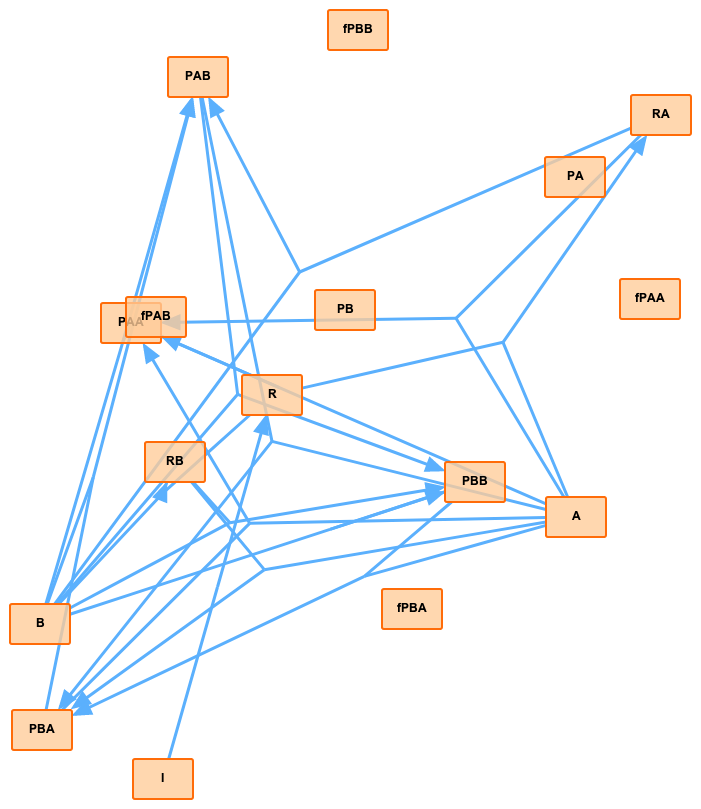

In [14]:
df = SBMLDiagrams.load(model_filename)

#df.autolayout()
df.draw(output_fileName='sbml_test.png')